# Conv-Net

### Libraries

In [1]:
%matplotlib notebook

import numpy as np # linear algebra
import os
import pickle
import matplotlib.pyplot as plt
import Lung_Segmentation as lung
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

### Dataset

In [2]:
pickle_in = open('F:\Prac_Clinicas\Images\Final_Pickle\Images_120px_0.pickle', 'rb')
Images_0 = np.array(pickle.load(pickle_in))

In [3]:
Images_0.shape

(135, 120, 120, 120)

In [4]:
pickle_in = open('F:\Prac_Clinicas\Images\Final_Pickle\Images_120px_1.pickle', 'rb')
Images_1 = np.array(pickle.load(pickle_in))

In [5]:
Images_1.shape

(868, 120, 120, 120)

### Normalization

In [6]:
from scipy import ndimage

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def process_scan(image):
    """Resize volume"""
    # Normalize
    volume = normalize(image)
    
    return volume

In [7]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(image) for image in Images_0])
normal_scans = np.array([process_scan(image) for image in Images_1])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:95], normal_scans[:608]), axis=0)
y_train = np.concatenate((abnormal_labels[:95], normal_labels[:608]), axis=0)
x_val = np.concatenate((abnormal_scans[95:], normal_scans[608:]), axis=0)
y_val = np.concatenate((abnormal_labels[95:], normal_labels[608:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 703 and 300.


### Free up RAM Space

In [8]:
Images_0=None
Images_1=None

### Plot images

<IPython.core.display.Javascript object>


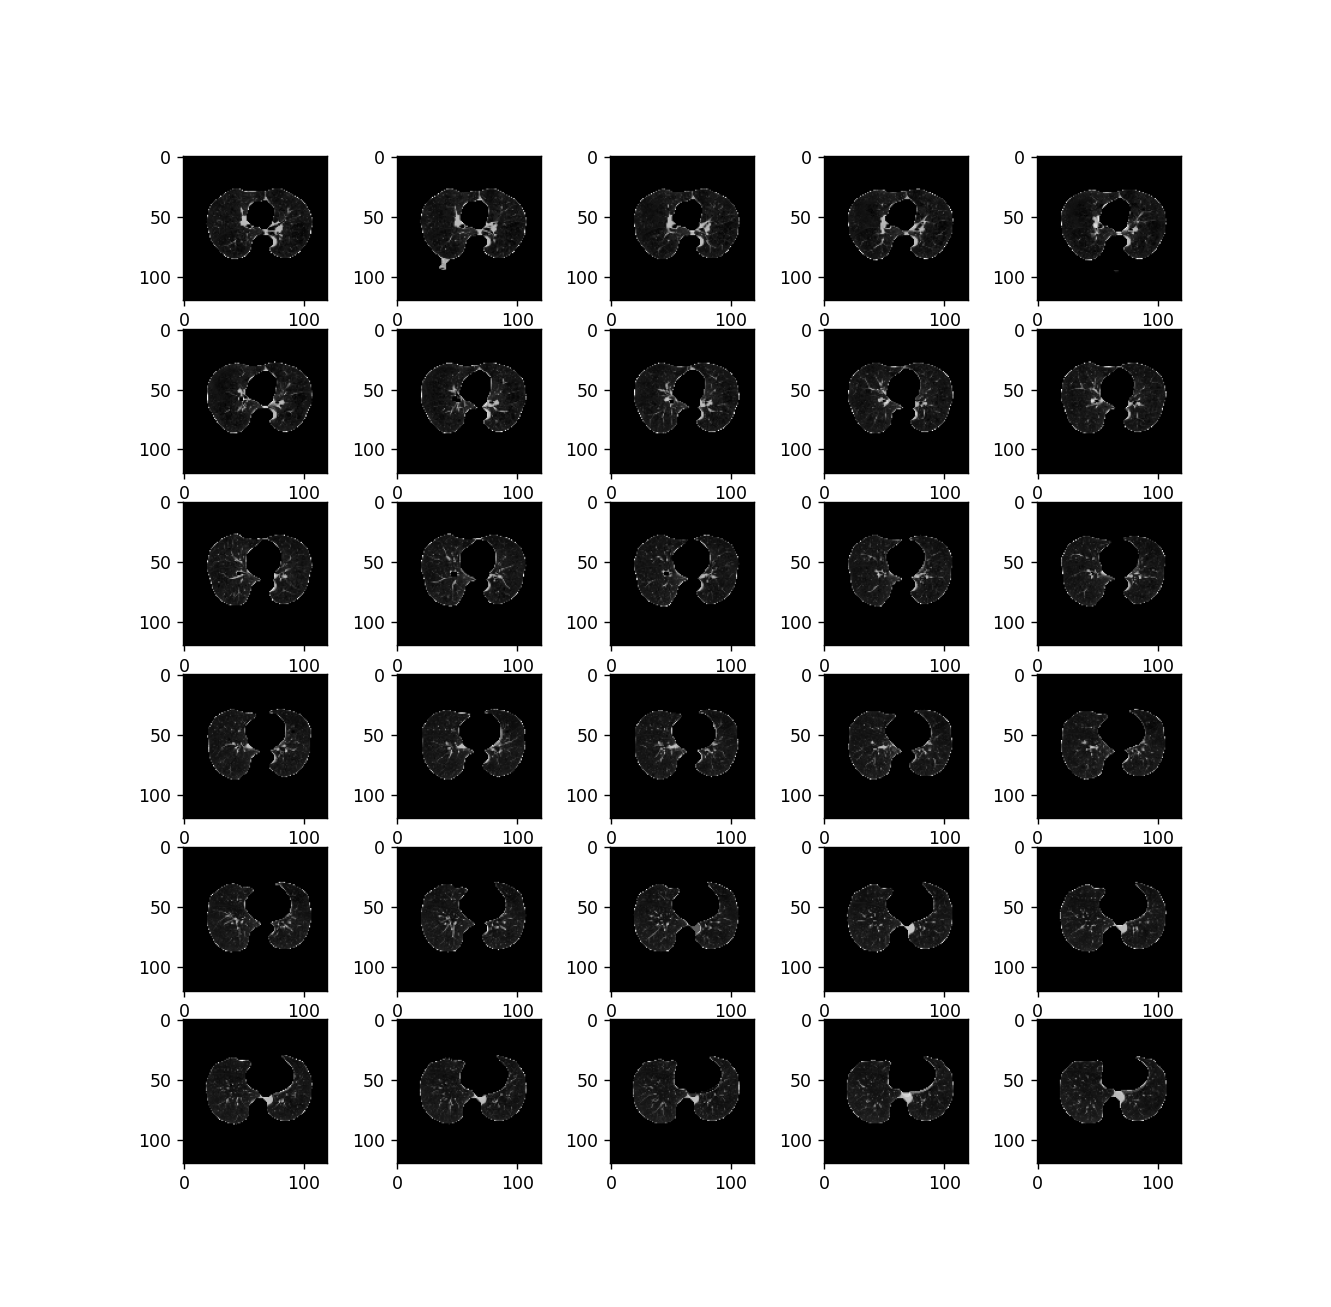

In [9]:
plt.figure()
for i in range(30):
    plt.subplot(6, 5, i+1), plt.imshow(x_train[0][i+50], 'gray')

### Data augmentation

In [10]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [11]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

### Model

In [7]:
def get_model(width=120, height=120, depth=120):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=120, height=120, depth=120)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 120, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 118, 118, 118, 64) 1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 59, 59, 59, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 59, 59, 59, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 57, 57, 57, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 28, 28, 28, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 28, 64)    256   

### Train

In [13]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Nodule_Classification_120px.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
352/352 - 178s - loss: 0.4675 - acc: 0.8563 - val_loss: 1.3588 - val_acc: 0.8667
Epoch 2/100
352/352 - 174s - loss: 0.4339 - acc: 0.8649 - val_loss: 0.4366 - val_acc: 0.8667
Epoch 3/100
352/352 - 171s - loss: 0.4185 - acc: 0.8649 - val_loss: 0.6420 - val_acc: 0.8667
Epoch 4/100
352/352 - 172s - loss: 0.3887 - acc: 0.8649 - val_loss: 0.6920 - val_acc: 0.8667
Epoch 5/100
352/352 - 192s - loss: 0.4095 - acc: 0.8649 - val_loss: 0.8288 - val_acc: 0.8667
Epoch 6/100
352/352 - 185s - loss: 0.4080 - acc: 0.8649 - val_loss: 0.5121 - val_acc: 0.8667
Epoch 7/100
352/352 - 189s - loss: 0.3964 - acc: 0.8649 - val_loss: 0.4187 - val_acc: 0.8667
Epoch 8/100
352/352 - 188s - loss: 0.3853 - acc: 0.8649 - val_loss: 0.4699 - val_acc: 0.8667
Epoch 9/100
352/352 - 188s - loss: 0.4019 - acc: 0.8649 - val_loss: 0.3946 - val_acc: 0.8667
Epoch 10/100
352/352 - 186s - loss: 0.3860 - acc: 0.8649 - val_loss: 0.4184 - val_acc: 0.8667
Epoch 11/100
352/352 - 187s - loss: 0.3841 - acc: 0.8649 - val_loss: 

### Visualizing model performance

<IPython.core.display.Javascript object>


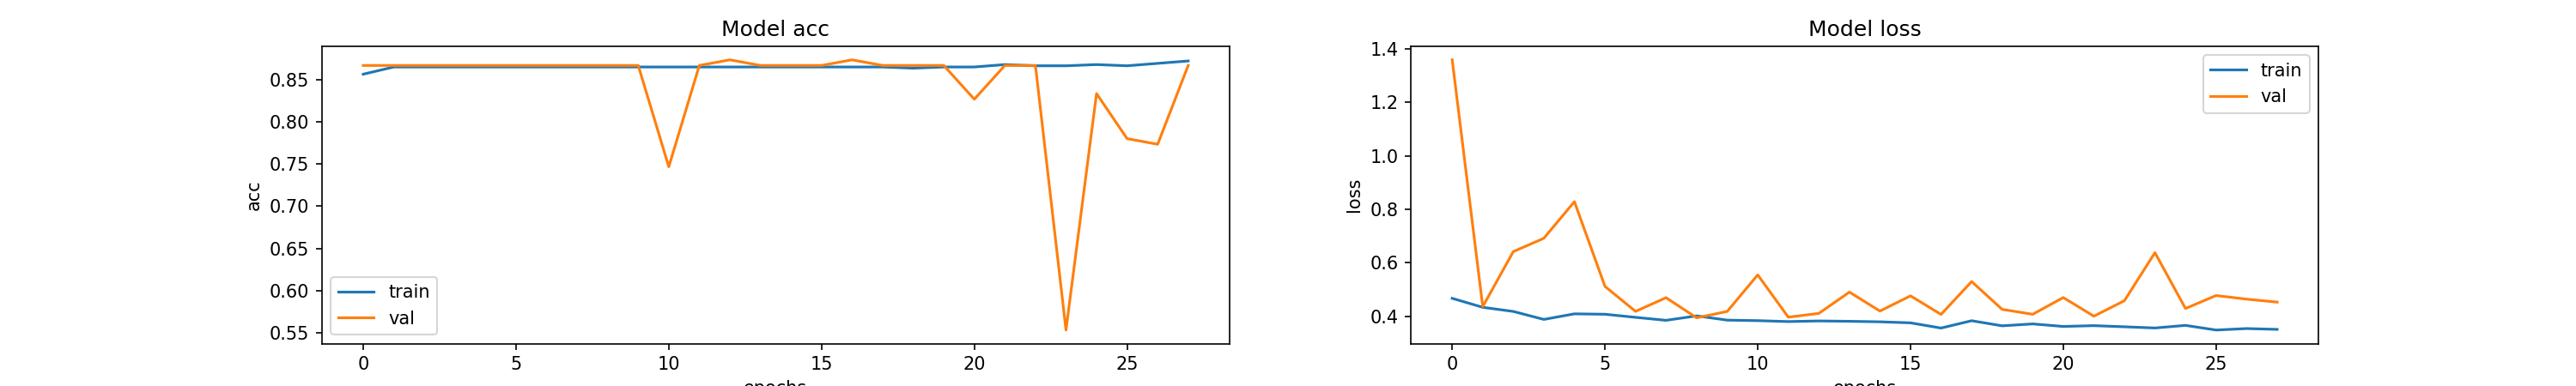

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Make predictions on a single CT scan

In [17]:
df = pd.read_excel('F:/Prac_Clinicas/LIDC-IDRI/Nodules_DF_1012.xlsx', index_col=0)

##### Predictions on Group 0

In [13]:
# Load best weights.
model.load_weights("Nodule_Classification_120px.h5")
print('Model confidence for each image. There are {} images.\n\nSmaller than 3 mm or none (Group 0)\nBigger than 3 mm (Group 1)'.format(len(abnormal_scans)))

for i in range(len(abnormal_scans)):
    prediction = model.predict(np.expand_dims(abnormal_scans[i], axis=0))[0]
    scores = [prediction[0], 1-prediction[0]]
    class_names = ["\n0)", "1)"]
    for score, name in zip(scores, class_names):
        print(
            "%s: %.2f "
            % (name, (100 * score))
        )

Model confidence for each image. There are 135 images.

Smaller than 3 mm or none (Group 0)
Bigger than 3 mm (Group 1)

0): 30.65 
1): 69.35 

0): 2.11 
1): 97.89 

0): 5.56 
1): 94.44 

0): 15.08 
1): 84.92 

0): 7.78 
1): 92.22 

0): 21.87 
1): 78.13 

0): 13.16 
1): 86.84 

0): 1.44 
1): 98.56 

0): 12.18 
1): 87.82 

0): 21.50 
1): 78.50 

0): 13.82 
1): 86.18 

0): 1.17 
1): 98.83 

0): 21.53 
1): 78.47 

0): 39.31 
1): 60.69 

0): 3.46 
1): 96.54 

0): 14.18 
1): 85.82 

0): 32.52 
1): 67.48 

0): 30.46 
1): 69.54 

0): 0.93 
1): 99.07 

0): 6.21 
1): 93.79 

0): 22.56 
1): 77.44 

0): 14.19 
1): 85.81 

0): 26.73 
1): 73.27 

0): 32.85 
1): 67.15 

0): 10.96 
1): 89.04 

0): 7.70 
1): 92.30 

0): 19.36 
1): 80.64 

0): 1.78 
1): 98.22 

0): 6.82 
1): 93.18 

0): 24.67 
1): 75.33 

0): 13.89 
1): 86.11 

0): 11.18 
1): 88.82 

0): 1.13 
1): 98.87 

0): 30.28 
1): 69.72 

0): 6.44 
1): 93.56 

0): 4.91 
1): 95.09 

0): 34.84 
1): 65.16 

0): 22.19 
1): 77.81 

0): 32.13 
1): 67.87

In [19]:
df.loc[df['Nodules'] == 0]

,Number,Nodules
TCIA Patent ID,,
LIDC-IDRI-0028,0,0.0
LIDC-IDRI-0032,0,0.0
LIDC-IDRI-0062,0,0.0
LIDC-IDRI-0071,0,0.0
LIDC-IDRI-0100,0,0.0
...,...,...
LIDC-IDRI-0975,0,0.0
LIDC-IDRI-0979,0,0.0
LIDC-IDRI-0988,0,0.0


##### Predictions on Group 1

In [14]:
# Load best weights.
model.load_weights("Nodule_Classification_120px.h5")
print('Model confidence for each image. There are {} images.\n\nSmaller than 3 mm or none (Group 0)\nBigger than 3 mm (Group 1)'.format(len(normal_scans)))

for i in range(len(normal_scans)):
    prediction = model.predict(np.expand_dims(normal_scans[i], axis=0))[0]
    scores = [prediction[0], 1-prediction[0]]
    class_names = ["\n0)", "1)"]
    for score, name in zip(scores, class_names):
        print(
            "%s: %.2f "
            % (name, (100 * score))
        )

Model confidence for each image. There are 868 images.

Smaller than 3 mm or none (Group 0)
Bigger than 3 mm (Group 1)

0): 20.13 
1): 79.87 

0): 8.05 
1): 91.95 

0): 8.11 
1): 91.89 

0): 8.86 
1): 91.14 

0): 28.77 
1): 71.23 

0): 19.27 
1): 80.73 

0): 0.15 
1): 99.85 

0): 12.06 
1): 87.94 

0): 3.91 
1): 96.09 

0): 5.76 
1): 94.24 

0): 7.86 
1): 92.14 

0): 9.58 
1): 90.42 

0): 1.81 
1): 98.19 

0): 2.08 
1): 97.92 

0): 11.54 
1): 88.46 

0): 7.95 
1): 92.05 

0): 11.13 
1): 88.87 

0): 26.49 
1): 73.51 

0): 13.06 
1): 86.94 

0): 12.03 
1): 87.97 

0): 5.20 
1): 94.80 

0): 1.54 
1): 98.46 

0): 24.98 
1): 75.02 

0): 15.73 
1): 84.27 

0): 4.46 
1): 95.54 

0): 20.67 
1): 79.33 

0): 22.95 
1): 77.05 

0): 3.54 
1): 96.46 

0): 3.10 
1): 96.90 

0): 15.83 
1): 84.17 

0): 16.07 
1): 83.93 

0): 18.00 
1): 82.00 

0): 12.15 
1): 87.85 

0): 18.03 
1): 81.97 

0): 2.29 
1): 97.71 

0): 10.69 
1): 89.31 

0): 9.70 
1): 90.30 

0): 11.56 
1): 88.44 

0): 26.23 
1): 73.77 

0


0): 28.45 
1): 71.55 

0): 10.22 
1): 89.78 

0): 3.58 
1): 96.42 

0): 15.57 
1): 84.43 

0): 0.13 
1): 99.87 

0): 16.31 
1): 83.69 

0): 20.02 
1): 79.98 

0): 2.94 
1): 97.06 

0): 21.25 
1): 78.75 

0): 30.82 
1): 69.18 

0): 6.85 
1): 93.15 

0): 18.75 
1): 81.25 

0): 5.51 
1): 94.49 

0): 27.92 
1): 72.08 

0): 21.49 
1): 78.51 

0): 8.47 
1): 91.53 

0): 2.77 
1): 97.23 

0): 3.97 
1): 96.03 

0): 19.33 
1): 80.67 

0): 22.63 
1): 77.37 

0): 18.12 
1): 81.88 

0): 7.58 
1): 92.42 

0): 6.08 
1): 93.92 

0): 20.00 
1): 80.00 

0): 12.37 
1): 87.63 

0): 4.73 
1): 95.27 

0): 24.14 
1): 75.86 

0): 5.96 
1): 94.04 

0): 9.04 
1): 90.96 

0): 0.66 
1): 99.34 

0): 32.87 
1): 67.13 

0): 0.27 
1): 99.73 

0): 13.29 
1): 86.71 

0): 25.27 
1): 74.73 

0): 3.55 
1): 96.45 

0): 33.92 
1): 66.08 

0): 17.19 
1): 82.81 

0): 7.14 
1): 92.86 

0): 2.03 
1): 97.97 

0): 6.72 
1): 93.28 

0): 23.18 
1): 76.82 

0): 3.19 
1): 96.81 

0): 4.74 
1): 95.26 

0): 19.33 
1): 80.67 

0): 7.42


0): 19.13 
1): 80.87 

0): 4.95 
1): 95.05 

0): 18.71 
1): 81.29 

0): 23.99 
1): 76.01 

0): 1.27 
1): 98.73 

0): 24.09 
1): 75.91 

0): 7.73 
1): 92.27 

0): 16.36 
1): 83.64 

0): 41.36 
1): 58.64 

0): 16.30 
1): 83.70 

0): 2.99 
1): 97.01 

0): 14.65 
1): 85.35 

0): 0.17 
1): 99.83 

0): 14.19 
1): 85.81 

0): 16.62 
1): 83.38 

0): 26.44 
1): 73.56 

0): 19.32 
1): 80.68 

0): 11.79 
1): 88.21 

0): 8.40 
1): 91.60 

0): 15.41 
1): 84.59 

0): 9.78 
1): 90.22 

0): 3.90 
1): 96.10 

0): 33.51 
1): 66.49 

0): 28.85 
1): 71.15 

0): 17.99 
1): 82.01 

0): 3.28 
1): 96.72 

0): 5.10 
1): 94.90 

0): 22.15 
1): 77.85 

0): 11.07 
1): 88.93 

0): 7.87 
1): 92.13 

0): 27.46 
1): 72.54 

0): 9.42 
1): 90.58 

0): 20.05 
1): 79.95 

0): 15.25 
1): 84.75 

0): 16.88 
1): 83.12 

0): 1.37 
1): 98.63 

0): 1.02 
1): 98.98 

0): 13.02 
1): 86.98 

0): 2.52 
1): 97.48 

0): 11.09 
1): 88.91 

0): 11.37 
1): 88.63 

0): 8.03 
1): 91.97 

0): 4.33 
1): 95.67 

0): 0.21 
1): 99.79 

0): 1

In [18]:
df.loc[df['Nodules'] == 1]

,Number,Nodules
TCIA Patent ID,,
LIDC-IDRI-0001,1,1.0
LIDC-IDRI-0002,1,1.0
LIDC-IDRI-0003,4,1.0
LIDC-IDRI-0004,1,1.0
LIDC-IDRI-0005,3,1.0
...,...,...
LIDC-IDRI-1008,6,1.0
LIDC-IDRI-1009,1,1.0
LIDC-IDRI-1010,1,1.0


### Data classification

Nodules smaller than 3 mm or none (0): 13,46%

Nodules bigger than 3 mm (1): 86,54%

### Discussion

- Not optimal distribution of data groups. Possible solution: multiclass with different diameter range.

- Compare to "Lung Cancer Detection and Classification with 3D Convolutional Neural Network (3D-CNN)" to see that we have good results.

- Sensitive but low specificity.

- Compare histogram distribution between 120px vs 60px.

- Limitations: Change from binary classification to nodule classification. Patients usualy have more than one nodule and some of them are lost by the resampling.